Best Parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Confusion Matrix:
[[44  4]
 [ 2 84]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.95      0.98      0.97        86

    accuracy                           0.96       134
   macro avg       0.96      0.95      0.95       134
weighted avg       0.96      0.96      0.96       134

ROC AUC Score: 0.986797480620155


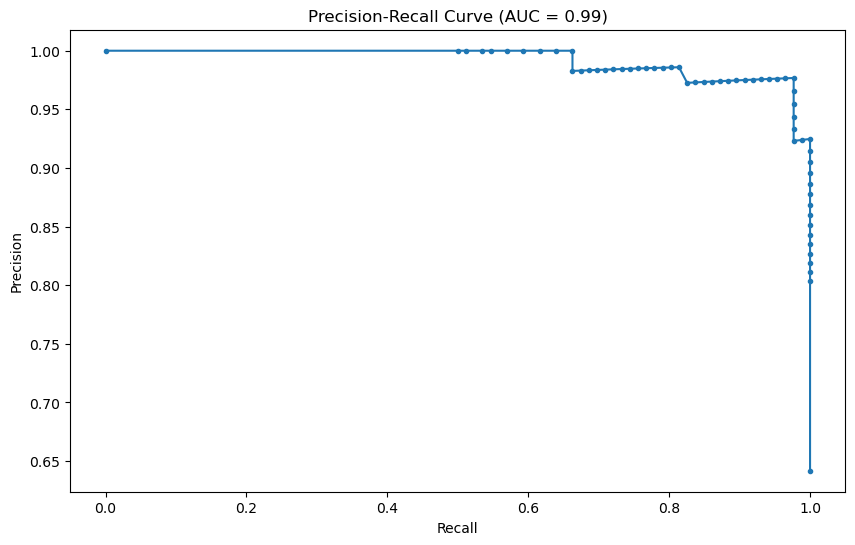

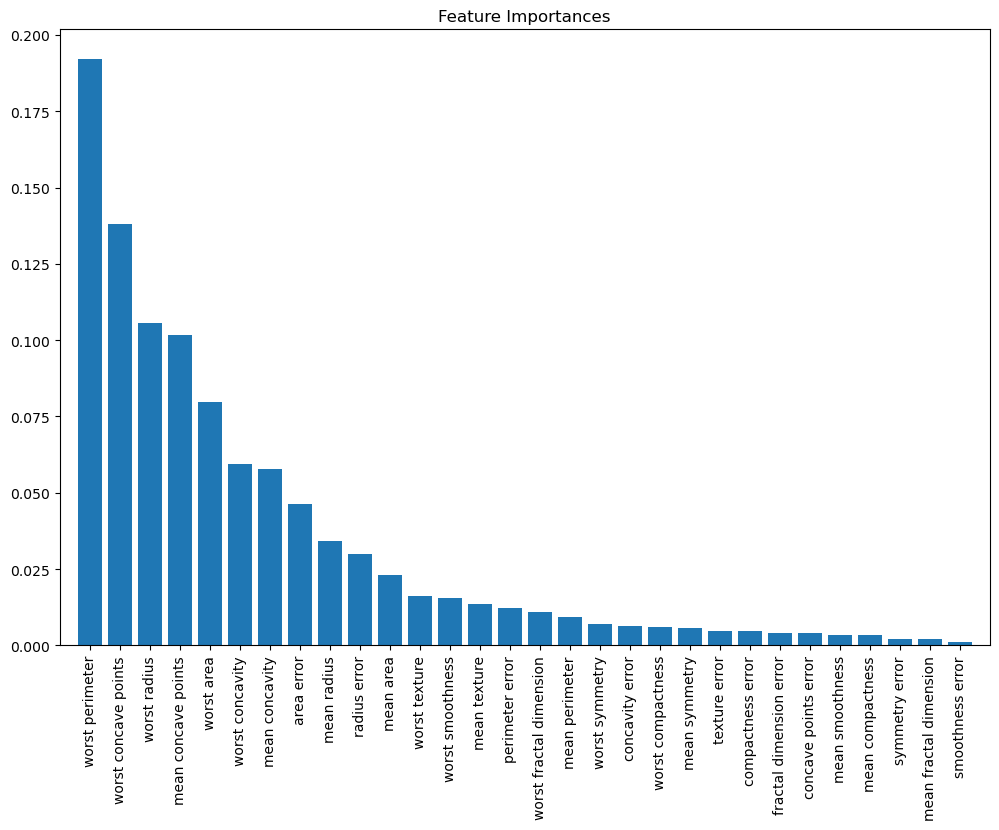

Cross-Validation Accuracy Scores: [0.93577982 0.99082569 0.97222222 1.         0.97222222]
Mean Cross-Validation Accuracy: 0.97420998980632
Predicted class for the new sample: malignant


In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline as SkPipeline


np.random.seed(0)


canc = load_breast_cancer()
df = pd.DataFrame(canc.data, columns=canc.feature_names)


df["type"] = pd.Categorical.from_codes(canc.target, canc.target_names)


df["is_train"] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df["is_train"] == True], df[df["is_train"] == False]


features = df.columns[:30]
X_train = train[features]
y_train = pd.factorize(train["type"])[0]
X_test = test[features]
y_test = pd.factorize(test["type"])[0]


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


smote = SMOTE(random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)


best_rf = grid_search.best_estimator_


best_rf.fit(X_train, y_train)


y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()


feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean()}")


sample = np.array([[5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 5.0, 3.6, 1.4, 2.0, 1.0, 9.0]])


sample_df = pd.DataFrame(sample, columns=features)


sample_scaled = scaler.transform(sample_df)


pred = canc.target_names[best_rf.predict(sample_scaled)]
print(f"Predicted class for the new sample: {pred[0]}")

